In [1]:
!pip install rasterstats

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
import rioxarray as rxr
import rasterio
import adlfs
import contextily as ctx
from tqdm import tqdm

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=4, local_directory='/tmp')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/egagli@uw.edu/proxy/8787/status,
Dashboard: /user/egagli@uw.edu/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: False
Comm: inproc://10.244.252.13/1544/1,Workers: 4
Dashboard: /user/egagli@uw.edu/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: inproc://10.244.252.13/1544/5,Total threads: 1
Dashboard: /user/egagli@uw.edu/proxy/32897/status,Memory: 8.00 GiB
Nanny: None,


In [4]:
gf = gpd.read_file('https://raw.githubusercontent.com/scottyhq/snotel/967b0071f3716118bfcae866c740cffb51fbb5f5/snotel-sites.geojson')

In [5]:
gf

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,mgrs,timeseries,geometry
0,301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,True,10TFL,True,POINT (-120.79192 41.23583)
1,907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,True,12SUG,True,POINT (-112.27118 37.52217)
2,916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,True,12TVR,True,POINT (-111.95902 45.59723)
3,1267_AK_SNTL,Alexander Lake,48.768002,61.749668,-150.889664,Matanuska-Susitna,Alaska,2014-08-28 00:00:00,2100-01-01,True,05VPJ,True,POINT (-150.88966 61.74967)
4,908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,True,10TET,True,POINT (-121.69847 47.77957)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,True,12SWC,True,POINT (-110.91773 33.81242)
926,1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,True,12SVJ,True,POINT (-111.35685 39.13233)
927,1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,True,12SUG,True,POINT (-112.77495 37.74797)
928,878_WY_SNTL,Younts Peak,2545.080078,43.932251,-109.817749,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,True,12TWP,True,POINT (-109.81775 43.93225)


In [6]:
snotel_gf = gf[gf.isActive==True]
snotel_gf = snotel_gf[(snotel_gf.beginDate<'2015-01-01') & (snotel_gf.endDate>'2022-01-01')]
snotel_gf = snotel_gf[snotel_gf.state!='Alaska']

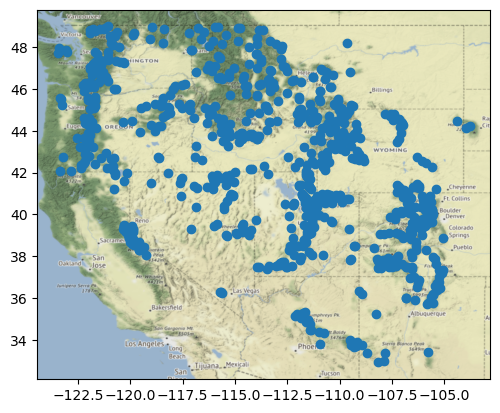

In [7]:
f,ax=plt.subplots()
snotel_gf.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=snotel_gf.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [8]:
#years = [2015,2016,2017,2018,2019,2020,2021,2022]
#years = [2016,2017,2018,2019,2020,2021,2022]
years = [2017,2018,2019,2020,2021,2022]
max_swe_years = [f'max_swe_{year}' for year in years]

In [9]:
for i,row in tqdm(snotel_gf.iterrows()):
    try:
        snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{row.code}.parquet').loc[slice(f'{years[0]}-01-01',f'{years[-1]}-12-31')]
        snotel_data = snotel_data[(snotel_data.index.month>1)&(snotel_data.index.month<10)]
        dates = snotel_data.groupby(snotel_data.index.year).idxmax()['WTEQ']
    #print(dates)
        if len(dates)==len(years):
            snotel_gf.loc[i,max_swe_years] = dates.values
    except:
        pass
    #date_index = []
    #for date in dates.index.values:
    #    date_index.append(f'max_swe_{date}')
    #snotel_gf = snotel_gf.loc[i,iter(date_index)] = dates.loc[2015:2022]

796it [05:28,  2.42it/s]


In [10]:
for year in years:
    snotel_gf[f'max_swe_{year}'] = pd.to_datetime(snotel_gf[f'max_swe_{year}']).dt.dayofyear

In [11]:
snotel_gf = snotel_gf.to_crs('EPSG:32611')

In [12]:
buffer = 2000 # at 1000m with 2015 excluded, medians of medians at 38 days, with 500m 34 days, with 200m 36.25 days, with 2000m 37 days
# 27 days new method 500m method, 22.0 with 1000m new new method, 23.5 with 500m new new method, 22.0 with 2000m
snotel_gf = gpd.GeoDataFrame(snotel_gf,geometry=snotel_gf.buffer(buffer))

In [13]:
sas_token = "se=2023-02-27T21%3A29Z&sp=racwdl&sv=2018-11-09&sr=c&skoid=b4d39ccb-ca9c-4e9d-a183-5e0f3ba3e609&sktid=f6b6dd5b-f02f-441a-99a0-162ac5060bd2&skt=2023-02-20T21%3A30%3A01Z&ske=2023-02-27T21%3A29%3A00Z&sks=b&skv=2018-11-09&sig=p0mG2aPIjQaBOhBFGGf%2BnGJLZhsarSAn2zoWfB0zxMA%3D"
tile_names = [tile[-5:] for tile in adlfs.AzureBlobFileSystem(account_name="snowmelt", credential=sas_token, anon=False).ls('snowmelt/eric/MGRS/')]

In [14]:
stats=['count', 'min', 'max', 'mean', 'median', 'std']

In [15]:
resolution = 80

In [16]:
for i,row in tqdm(snotel_gf.iterrows()):
    if row.mgrs in tile_names:
        #print(f'{row.code} in MGRS square {row.mgrs}')
        for year in years:
            try:
                raster = rasterio.open(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_{year}_median_{resolution}m.tif")
                snotel_row_proj = snotel_gf[snotel_gf.index==i].to_crs(raster.crs)
                statistics = rasterstats.zonal_stats(snotel_row_proj, raster.read(1), affine=raster.transform, stats=stats, nodata=-32768)
                snotel_gf.loc[i,f'sar_runoff_{year}'] = statistics[0]['median']
                if year == 2022:
                    snotel_gf.loc[i,f'sar_runoff_pixel_count'] = statistics[0]['count']
            except:
            #print(f'Error with tile {row.mgrs} for year {year}')
                pass


796it [09:32,  1.39it/s]


In [17]:
for year in years:
        snotel_gf[f'offset_{year}'] = snotel_gf[f'max_swe_{year}'] - snotel_gf[f'sar_runoff_{year}']

In [18]:
snotel_gf['median_offset'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('offset')]].abs().median(axis=1)
snotel_gf['mean_offset'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('offset')]].abs().mean(axis=1)

In [19]:
snotel_gf.sort_values('mean_offset').head(20)
#snotel_gf.sort_values('median_offset').head(20)

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,sar_runoff_2022,sar_runoff_pixel_count,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset
608,673_WY_SNTL,Old Battle,3048.000000,41.153969,-106.969368,Carbon,Wyoming,1962-09-01,2100-01-01,True,...,125.0,167.0,8.0,1.0,21.0,-2.0,0.0,0.0,1.5,5.333333
866,838_CO_SNTL,University Camp,3139.439941,40.032791,-105.576149,Boulder,Colorado,1978-10-01,2100-01-01,True,...,139.0,126.0,0.0,3.0,0.0,-14.5,1.0,-14.0,2.0,5.416667
390,541_CA_SNTL,Independence Lake,2541.422363,39.427521,-120.313423,Nevada,California,1978-10-01,2100-01-01,True,...,104.0,98.0,12.0,1.0,-5.0,2.0,-7.0,11.0,6.0,6.333333
639,1263_WA_SNTL,Pinto Rock,1353.312012,46.323181,-121.942192,Skamania,Washington,2014-10-01,2100-01-01,True,...,117.0,45.0,10.0,15.0,2.0,-3.0,-6.0,3.0,4.5,6.500000
37,1061_CO_SNTL,Bear River,2767.583984,40.061531,-107.009552,Routt,Colorado,2004-10-01,2100-01-01,True,...,96.0,413.0,11.0,3.0,-6.0,9.0,1.0,10.0,7.5,6.666667
187,420_WA_SNTL,Cougar Mountain,975.359985,47.276661,-121.671379,King,Washington,1979-10-01,2100-01-01,True,...,108.0,27.0,6.0,18.0,3.0,2.0,11.0,3.0,4.5,7.166667
908,862_MT_SNTL,White Mill,2651.760010,45.045750,-109.909866,Park,Montana,1966-10-01,2100-01-01,True,...,130.0,561.0,-3.0,-16.0,1.0,-7.0,-12.0,5.0,6.0,7.333333
891,850_MT_SNTL,Warm Springs,2377.439941,46.273682,-113.164001,Granite,Montana,1977-07-01,2100-01-01,True,...,140.0,173.0,13.0,5.0,9.0,-6.0,-7.0,-4.0,6.5,7.333333
83,353_WY_SNTL,Blind Bull Sum,2636.520020,42.964001,-110.609734,Sublette,Wyoming,1978-10-01,2100-01-01,True,...,133.0,1611.0,1.0,-7.0,-31.0,1.0,-2.0,-2.0,2.0,7.333333
885,846_CA_SNTL,Virginia Lakes Ridge,2878.835938,38.072979,-119.234329,Mono,California,1978-10-01,2100-01-01,True,...,93.0,969.0,-4.0,-23.0,-7.0,6.0,-3.0,-4.0,5.0,7.833333


Text(0.5, 0, 'Offset [Days]')

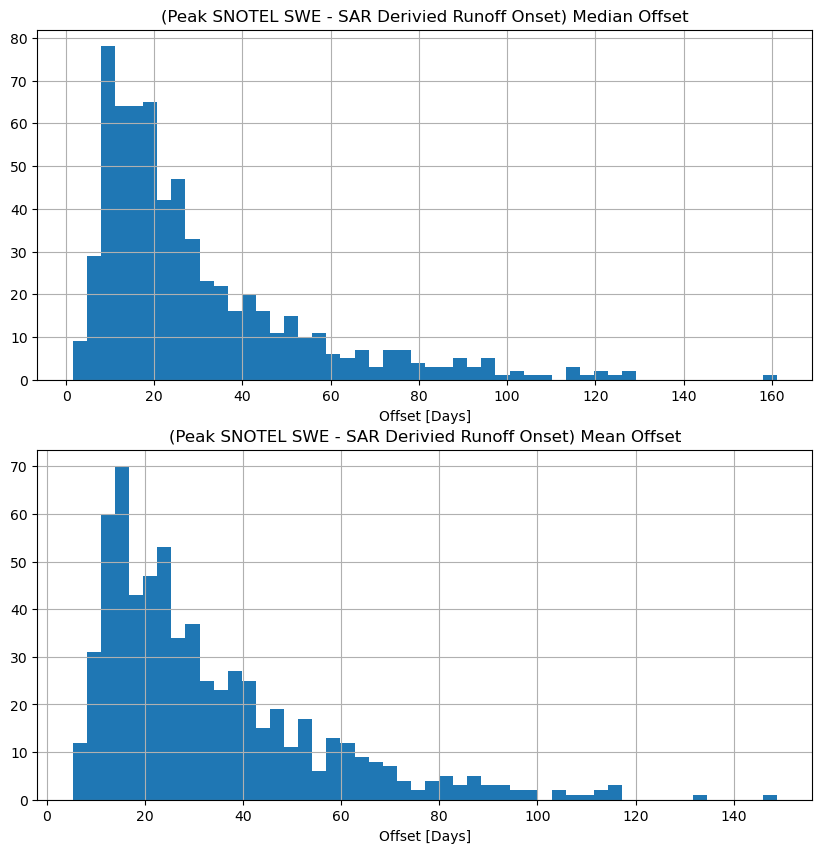

In [20]:
f,ax=plt.subplots(2,1,figsize=(10,10))
snotel_gf['median_offset'].hist(bins=50,ax=ax[0])
snotel_gf['mean_offset'].hist(bins=50,ax=ax[1])
ax[0].set_title('(Peak SNOTEL SWE - SAR Derivied Runoff Onset) Median Offset')
ax[1].set_title('(Peak SNOTEL SWE - SAR Derivied Runoff Onset) Mean Offset')
ax[0].set_xlabel('Offset [Days]')
ax[1].set_xlabel('Offset [Days]')

In [21]:
snotel_gf['median_offset'].median()
# 25 all years
# 22.5 2017 on

22.0

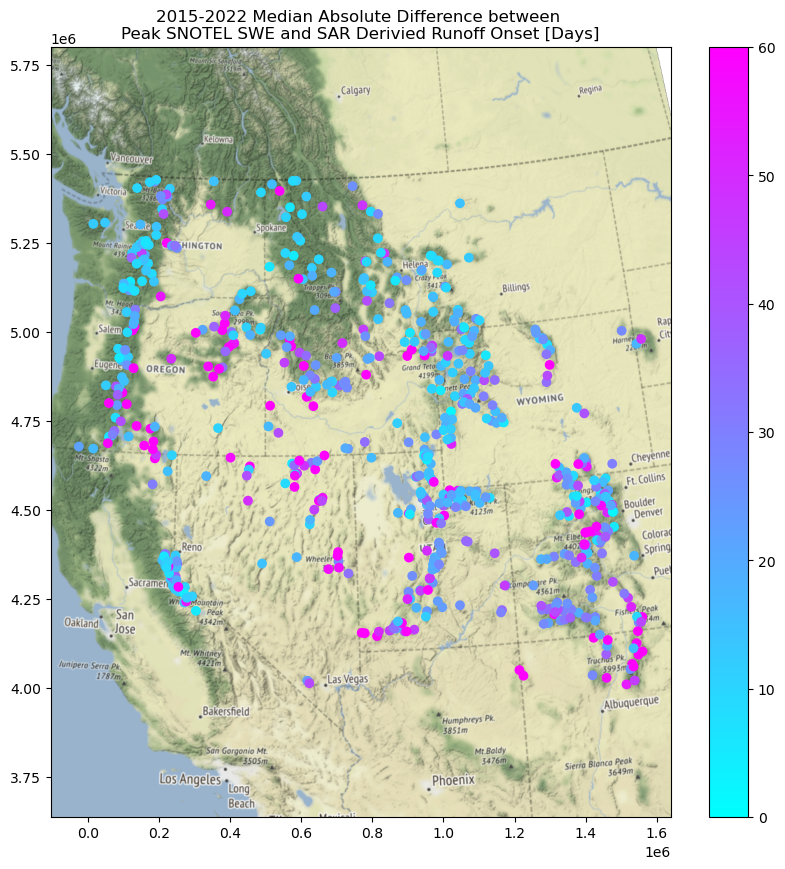

In [22]:
f,ax=plt.subplots(figsize=(10,10))
snotel_gf_projected = gpd.GeoDataFrame(snotel_gf,geometry=gf.geometry).to_crs('EPSG:32611')
snotel_gf_projected.plot(column='median_offset',ax=ax,legend=True,cmap='cool',vmin=0,vmax=60)
ax.axis('equal')
ax.set_title('2015-2022 Median Absolute Difference between \nPeak SNOTEL SWE and SAR Derivied Runoff Onset [Days]')
ctx.add_basemap(ax=ax, crs=snotel_gf_projected.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [23]:
tooltip_list = ['code','name','elevation_m']
for year in years:
    tooltip_list.append(f'offset_{year}')                
tooltip_list.extend(['median_offset','mean_offset','sar_runoff_pixel_count'])

In [24]:
snotel_gf_projected = snotel_gf_projected.drop(['beginDate','endDate','isActive','timeseries'],axis=1)

In [25]:
snotel_gf_projected.explore(column='median_offset',cmap='cool',tooltip=tooltip_list,vmin=0,vmax=60)

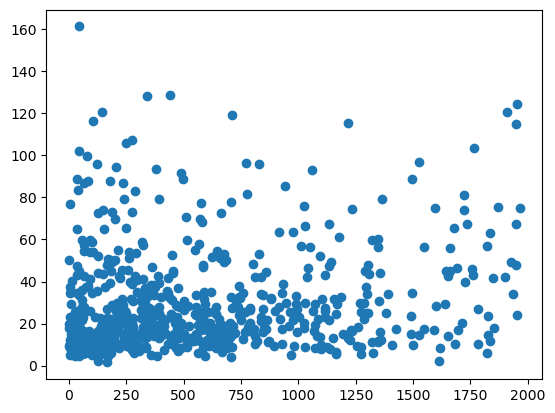

In [26]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['sar_runoff_pixel_count'],snotel_gf_projected['median_offset'])
#ax.set_xlim([0,10])

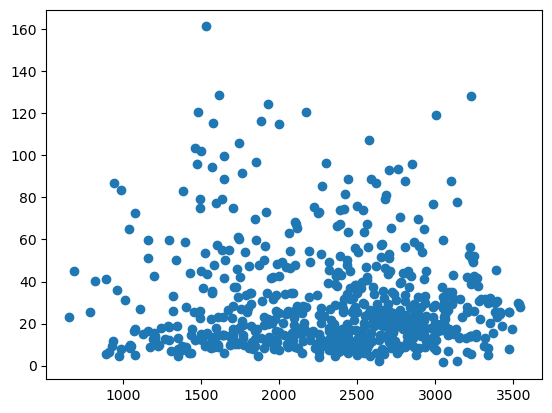

In [27]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['elevation_m'],snotel_gf_projected['median_offset'])

In [28]:
snotel_gf_projected.corr()

,elevation_m,latitude,longitude,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022,sar_runoff_2017,...,sar_runoff_2022,sar_runoff_pixel_count,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset
elevation_m,1.000000,-0.685418,0.798646,0.186931,0.099537,0.449736,0.317401,0.253791,0.191599,0.075250,...,0.033798,0.213441,0.086858,0.051102,-0.017402,0.048735,-0.002442,0.089712,-0.068359,-0.088538
latitude,-0.685418,1.000000,-0.493469,0.339846,0.484085,0.131117,0.256806,0.327532,0.366084,-0.042536,...,0.011862,-0.233268,0.214588,0.163293,0.136569,0.178616,0.166941,0.227970,-0.220059,-0.213360
longitude,0.798646,-0.493469,1.000000,-0.000501,0.071342,0.279550,0.240091,0.207681,0.178817,0.077665,...,0.065843,0.075947,-0.034592,0.018459,-0.117390,-0.042335,-0.045659,0.081127,0.024109,0.011306
max_swe_2017,0.186931,0.339846,-0.000501,1.000000,0.696265,0.712332,0.644313,0.695712,0.710321,0.020594,...,-0.028322,-0.043773,0.692997,0.357013,0.318894,0.356222,0.320264,0.493570,-0.508579,-0.534794
max_swe_2018,0.099537,0.484085,0.071342,0.696265,1.000000,0.647236,0.721659,0.736403,0.737777,-0.065327,...,-0.064430,-0.125469,0.517781,0.498864,0.279627,0.450830,0.355447,0.541253,-0.551388,-0.565772
max_swe_2019,0.449736,0.131117,0.279550,0.712332,0.647236,1.000000,0.680933,0.705482,0.673777,0.016051,...,-0.016886,0.021021,0.468331,0.333532,0.414392,0.343193,0.337818,0.455775,-0.485720,-0.507491
max_swe_2020,0.317401,0.256806,0.240091,0.644313,0.721659,0.680933,1.000000,0.750711,0.706685,-0.074326,...,-0.073180,-0.105938,0.483763,0.369852,0.236578,0.638754,0.364924,0.527308,-0.583348,-0.585278
max_swe_2021,0.253791,0.327532,0.207681,0.695712,0.736403,0.705482,0.750711,1.000000,0.755746,-0.018456,...,0.001120,-0.085251,0.478739,0.391619,0.269494,0.398867,0.524877,0.515870,-0.487465,-0.511235
max_swe_2022,0.191599,0.366084,0.178817,0.710321,0.737777,0.673777,0.706685,0.755746,1.000000,-0.015983,...,-0.003459,-0.109635,0.498450,0.366649,0.242627,0.383546,0.337217,0.692501,-0.496125,-0.509437
sar_runoff_2017,0.075250,-0.042536,0.077665,0.020594,-0.065327,0.016051,-0.074326,-0.018456,-0.015983,1.000000,...,0.311021,0.091413,-0.706517,-0.087905,-0.212607,-0.348051,-0.265254,-0.216196,0.413982,0.403463


In [29]:
snotel_gf_projected.describe()

,elevation_m,latitude,longitude,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022,sar_runoff_2017,...,sar_runoff_2022,sar_runoff_pixel_count,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset
count,796.000000,796.000000,796.000000,728.000000,726.000000,728.000000,727.000000,730.000000,730.000000,705.000000,...,699.000000,707.000000,646.000000,644.000000,646.000000,645.000000,648.000000,643.000000,648.000000,648.000000
mean,2300.085130,42.231755,-113.214811,85.990385,92.037190,94.732143,92.562586,88.702740,92.523288,110.873759,...,126.257511,599.046676,-23.797214,-29.418478,-28.777864,-21.533333,-28.676698,-32.083981,29.897762,33.110082
std,642.544918,3.651480,5.231593,26.147317,18.767176,19.494886,21.908805,20.180342,28.214058,26.212805,...,29.396951,518.080926,35.698901,44.748033,33.911316,33.734222,34.209827,39.801013,24.299607,22.599536
min,128.016006,32.924011,-123.457474,32.000000,32.000000,33.000000,32.000000,32.000000,32.000000,54.000000,...,46.000000,0.000000,-158.000000,-220.000000,-165.000000,-170.000000,-161.000000,-165.000000,1.500000,5.333333
25%,1829.562012,39.406603,-117.095798,67.000000,83.000000,77.750000,90.000000,84.000000,74.000000,95.000000,...,108.000000,180.000000,-39.000000,-48.000000,-38.000000,-34.000000,-45.250000,-54.000000,13.437500,16.125000
50%,2400.299927,42.135935,-111.957687,72.000000,94.000000,95.000000,96.000000,86.000000,91.000000,108.000000,...,123.000000,458.000000,-21.000000,-15.000000,-22.000000,-12.000000,-21.000000,-27.000000,22.000000,26.333333
75%,2785.033691,45.068324,-109.369423,114.250000,108.000000,107.000000,108.000000,101.000000,115.000000,123.000000,...,140.000000,906.000000,2.000000,-3.000000,-7.000000,-1.000000,-6.000000,-4.000000,38.125000,42.500000
max,3541.775879,48.980751,-103.787582,143.000000,207.000000,155.000000,137.000000,160.000000,171.000000,231.000000,...,231.000000,1965.000000,55.000000,87.000000,51.000000,48.000000,68.000000,75.000000,161.250000,148.833333
